In [32]:
from matplotlib import style
import seaborn as sns
from scipy.stats import randint as sp_randint
from sklearn.decomposition import PCA
from pathlib import Path
import pandas as pd
import numpy as np

In [33]:
style.use("ggplot")

# loading the data

github_p = "https://github.com/Finance-781/FinML/blob/master/Lecture%207%20-%20Principal%20Components/Inclass/data"

my_file = Path("Dow_adjcloses.csv") # Defines path
if my_file.is_file():              # See if file exists
    print("Local file found")      
    df = pd.read_csv('Dow_adjcloses.csv', parse_dates=True, index_col=0)
else:
    print("Be patient: loading from github (2 minutes)")
    df = pd.read_csv(github_p+'data/Dow_adjcloses.csv', parse_dates=True, index_col=0)
    print("Done")
df.head()

Local file found


,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DIS,DWDP,...,NKE,PFE,PG,TRV,UTX,UNH,VZ,V,WMT,WBA
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,29.847043,35.476634,3.530576,26.650218,14.560887,21.582046,43.003876,16.983583,23.522220,NaN,...,4.701180,16.746856,32.227726,20.158885,21.319030,5.841355,22.564221,NaN,47.337599,21.713237
2000-01-04,28.661131,34.134275,3.232839,26.610431,14.372251,21.582046,40.577200,17.040950,24.899860,NaN,...,4.445214,16.121738,31.596399,19.890099,20.445803,5.766368,21.833915,NaN,45.566248,20.907354
2000-01-05,30.122175,33.959430,3.280149,28.473758,14.914205,22.049145,40.895453,17.228147,25.781550,NaN,...,4.702157,16.415912,31.325831,20.085579,20.254784,5.753327,22.564221,NaN,44.503437,21.097421
2000-01-06,31.877325,33.959430,2.996290,28.553331,15.459153,22.903343,39.781569,17.210031,24.899860,NaN,...,4.677733,16.972739,32.438168,20.122232,20.998392,5.964159,22.449405,NaN,45.126952,20.527220
2000-01-07,32.509812,34.433913,3.138219,29.382213,15.962182,23.305926,42.128682,18.342270,24.506249,NaN,...,4.677733,18.123166,35.023602,20.922479,21.830687,6.662948,22.282692,NaN,48.535033,21.051805


In [34]:
df.drop(['DWDP', 'V'], axis=1, inplace=True)
data = pd.DataFrame(df.copy())
# Daily Linear Returns (%)
datareturns = data.pct_change(1)

In [35]:
# Dow Jones Equal Weighted RETURN
datareturns["DJIA"] = datareturns.mean(axis=1)

# Data Raw
data_raw = datareturns
data_raw.dropna(how='all', inplace=True)

# Normalizing the returns
data = (data_raw - data_raw.mean()) / data_raw.std()

# Getting rid of the NaN values.
data.dropna(how='any', inplace=True)
data_raw.dropna(how='any', inplace=True)

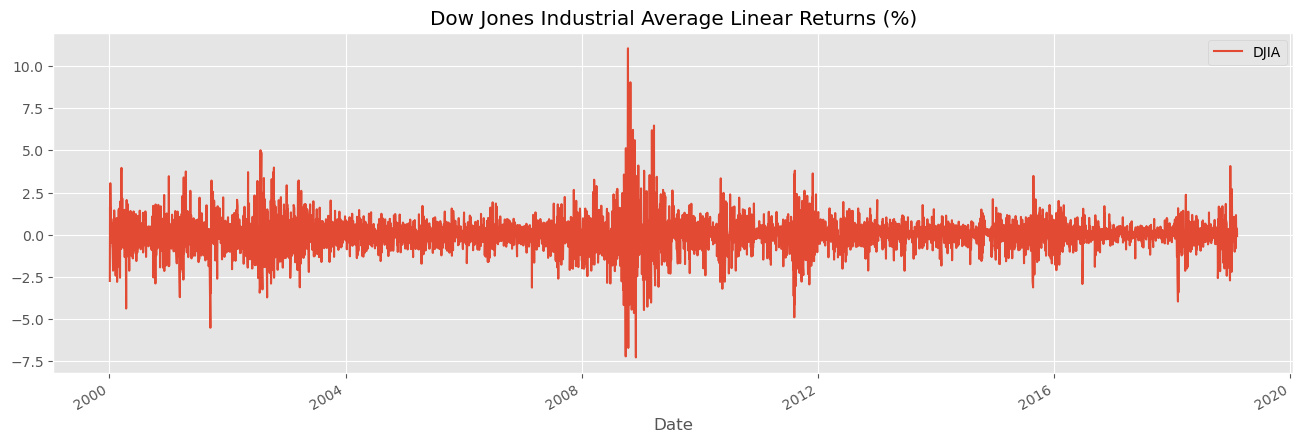

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 5))
plt.title("Dow Jones Industrial Average Linear Returns (%)")
data.DJIA.plot()
plt.grid(True);
plt.legend()
plt.show()

In [37]:
# Taking away the market benchmark DJIA
stock_tickers = data.columns.values[:-1]
n_tickers = len(stock_tickers)

# Dividing the dataset into training and testing sets
percentage = int(len(data) * 0.8)
X_train = data[:percentage]
X_test = data[percentage:]

X_train_raw = data_raw[:percentage]
X_test_raw = data_raw[percentage:]

In [38]:
# Applying Principle Component Analysis
# Creating covariance matrix and training data on PCA.
cov_matrix = X_train.loc[:,X_train.columns != 'DJIA'].cov()
pca = PCA()
pca.fit(cov_matrix)

PCA()

21 principal components explain 95.00% of variance


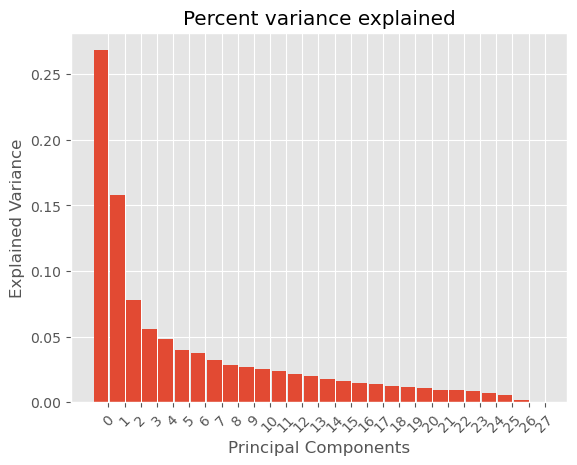

In [39]:
def plotPCA(plot=False):

    # Visualizing Variance against number of principal components.
    cov_matrix_raw = X_train_raw.loc[:,X_train_raw.columns != 'DJIA'].cov()

    var_threshold = 0.95
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    num_comp = np.where(np.logical_not(var_explained < var_threshold))[0][0] + 1  

    if plot:
        print('%d principal components explain %.2f%% of variance' %(num_comp, 100* var_threshold))

        # PCA percent variance explained.
        bar_width = 0.9
        n_asset = stock_tickers.shape[0]
        x_indx = np.arange(n_asset)
        fig, ax = plt.subplots()

        # Eigenvalues measured as percentage of explained variance.
        rects = ax.bar(x_indx, pca.explained_variance_ratio_[:n_asset], bar_width)
        ax.set_xticks(x_indx + bar_width / 2)
        ax.set_xticklabels(list(range(n_asset)), rotation=45)
        ax.set_title('Percent variance explained')
        ax.set_ylabel('Explained Variance')
        ax.set_xlabel('Principal Components')
        plt.show()

plotPCA(plot=True)

In [40]:
projected = pca.fit_transform(cov_matrix)
pcs = pca.components_

#### Some general functions that will be used to compare results

In [42]:
### Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #18 with the highest Sharpe. Return 73.22%, vol = 52.77%, Sharpe = 1.39
      Return       Vol    Sharpe
18  0.732203  0.527742  1.387424
4   0.591001  0.655269  0.901922
22  0.496591  0.591244  0.839909
15  0.564721  0.812595  0.694961
0   0.380484  0.632765  0.601304
9   0.314115  0.542399  0.579123
26  0.298652  0.617072  0.483983
7   0.429301  0.930989  0.461124
13  0.162942  0.685799  0.237595
20  0.230046  1.636941  0.140534


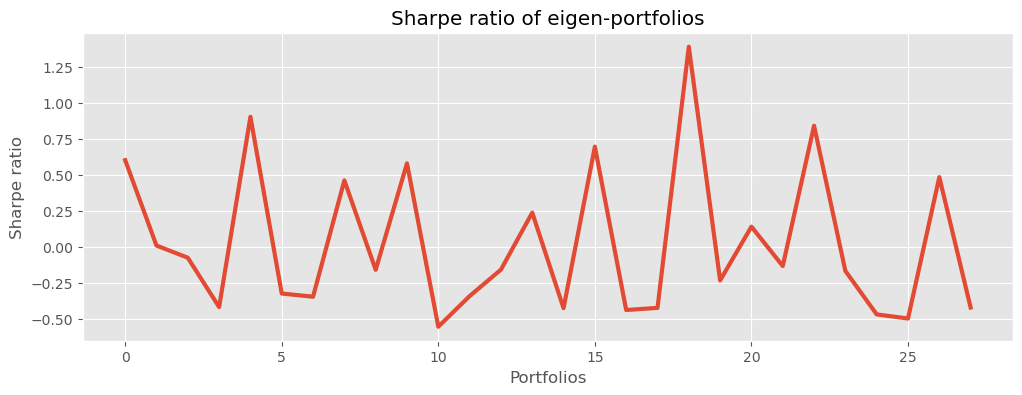

In [43]:
def optimizedPortfolio():
    n_portfolios = len(pcs)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 

    for i in range(n_portfolios):
        
        pc_w = pcs[:, i] / sum(pcs[:, i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        
        eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen_prtfi / n_portfolios)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe

    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(10))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

/var/folders/p9/49qqydtn3lz94zb596f_slc40000gn/T/ipykernel_68150/2016594765.py:21: FutureWarning:

Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead



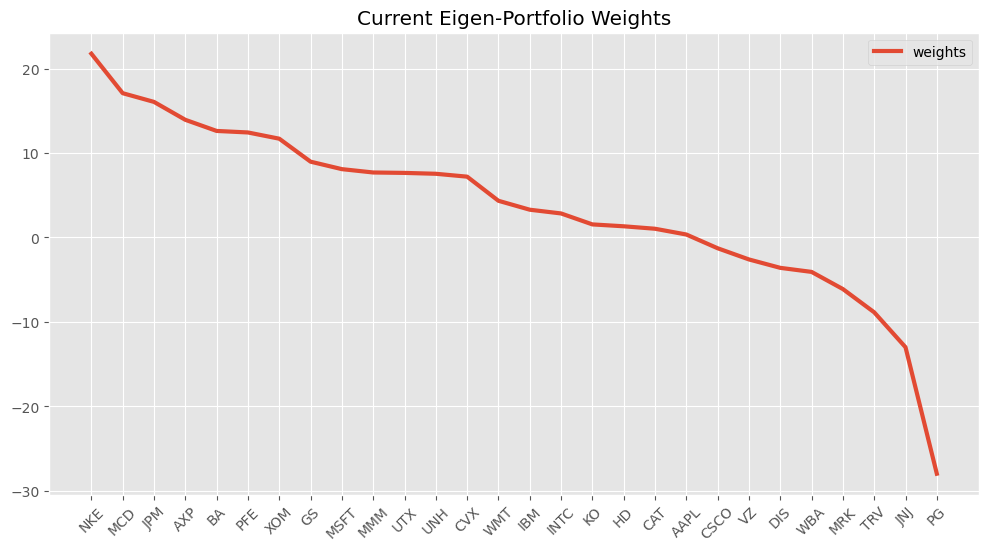

,weights
NKE,21.756781
MCD,17.083256
JPM,16.051491
AXP,13.932022
BA,12.613809
PFE,12.433935
XOM,11.696040
GS,8.975823
MSFT,8.091432
MMM,7.695248


In [44]:
def PCWeights():
    '''
    Principal Components (PC) weights for each 28 PCs
    '''
    weights = pd.DataFrame()

    for i in range(len(pcs)):
        weights["weights_{}".format(i)] = pcs[:, i] / sum(pcs[:, i])

    weights = weights.values.T
    return weights

weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()

    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[4], plot=True)

Current Eigen-Portfolio:
Return = 59.10%
Volatility = 65.53%
Sharpe = 0.90


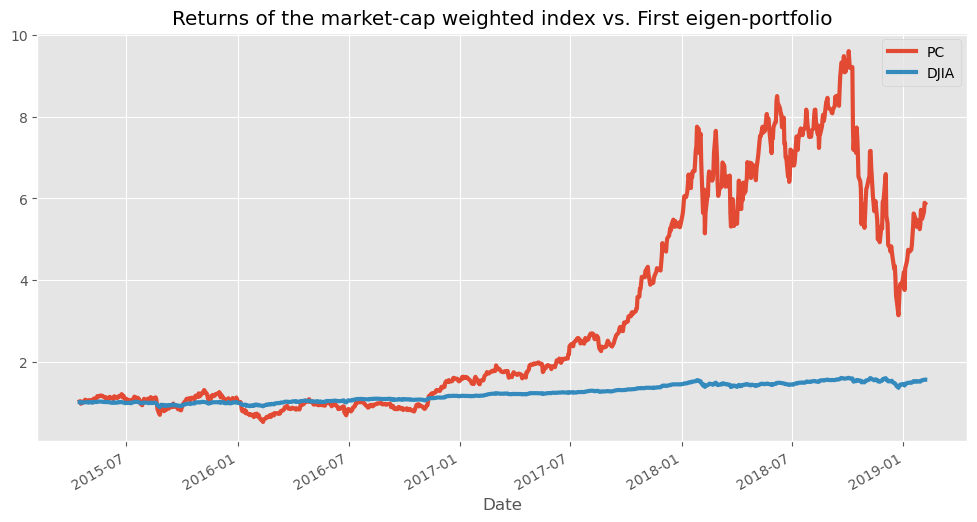

In [45]:
def plotSharpe(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''

    eigen_portfolio_returns = np.dot(X_test_raw.loc[:, eigen.index], eigen / len(pcs))
    eigen_portfolio_returns = pd.Series(eigen_portfolio_returns.squeeze(), index=X_test.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    year_frac = (eigen_portfolio_returns.index[-1] - eigen_portfolio_returns.index[0]).days / 252

    df_plot = pd.DataFrame({'PC': eigen_portfolio_returns, 'DJIA': X_test_raw.loc[:, 'DJIA']}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the market-cap weighted index vs. First eigen-portfolio', 
                             figsize=(12,6), linewidth=3)
    plt.show()

plotSharpe(eigen=plotEigen(weights=weights[4]))